# Twitter Sentimental Analysis

## Importing Libraries

In [1]:
import re
import pickle
import numpy as np
import pandas as pd

import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report

## Importing Dataset

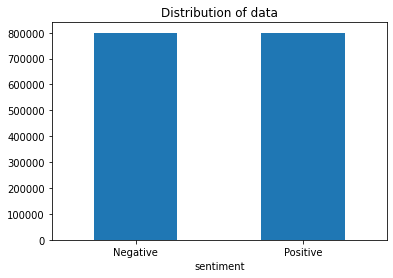

In [2]:
# Importing the dataset
dataset_col  = ["sentiment", "ids", "date", "flag", "user", "text"]
dataset_enc = "ISO-8859-1"
dataset = pd.read_csv('/kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv', encoding=dataset_enc , names=dataset_col)

# Removing the unnecessary columns.
dataset = dataset[['sentiment','text']]
# Replacing the values to ease understanding.
dataset['sentiment'] = dataset['sentiment'].replace(4,1)

# Plotting the distribution for dataset.
ax = dataset.groupby('sentiment').count().plot(kind='bar', title='Distribution of data', legend=False)
ax.set_xticklabels(['Negative','Positive'], rotation=0)

# Storing data in lists.
text, sentiment = list(dataset['text']), list(dataset['sentiment'])

**Text Preprocessing** is traditionally an important step for Natural Language Processing (NLP) tasks. It transforms text into a more digestible form so that machine learning algorithms can perform better.

The Preprocessing steps taken are:

1. Lower Casing: Each text is converted to lowercase. Replacing URLs: Links starting with "http" or "https" or "www" are replaced by "URL".
2. Replacing Emojis: Replace emojis by using a pre-defined dictionary containing emojis along with their meaning. (eg: ":)" to "EMOJIsmile")
3. Replacing Usernames: Replace @Usernames with word "USER". (eg: "@Kaggle" to "USER")
4. Removing Non-Alphabets: Replacing characters except Digits and Alphabets with a space.
5. Removing Consecutive letters: 3 or more consecutive letters are replaced by 2 letters. (eg: "Heyyyy" to "Heyy")
6. Removing Short Words: Words with length less than 2 are removed.
7. Removing Stopwords: Stopwords are the English words which does not add much meaning to a sentence. They can safely be ignored without sacrificing the meaning of the sentence. (eg: "the", "he", "have")
8. Lemmatizing: Lemmatization is the process of converting a word to its base form. (e.g: “Great” to “Good”)

In [3]:
# Defining dictionary containing all emojis with their meanings.
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', 
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', 
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

## Defining set containing all stopwords in english.
stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from', 
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're',
             's', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those', 
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']

In [4]:
def preprocess(textdata):
    processedText = []
    
    # Create Lemmatizer and Stemmer
    wordLemm = WordNetLemmatizer()
    
    # Regex patterns
    urlPattern = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    userPattern       = '@[^\s]+'
    alphaPattern      = "[^a-zA-Z0-9]"
    sequencePattern   = r"(.)\1\1+"
    seqReplacePattern = r"\1\1"
    
    for tweet in textdata:
        tweet = tweet.lower()
        
        # Replace all URls with 'URL'
        tweet = re.sub(urlPattern,' URL',tweet)
        # Replace all emojis.
        for emoji in emojis.keys():
            tweet = tweet.replace(emoji, "EMOJI" + emojis[emoji])        
        # Replace @USERNAME to 'USER'.
        tweet = re.sub(userPattern,' USER', tweet)        
        # Replace all non alphabets.
        tweet = re.sub(alphaPattern, " ", tweet)
        # Replace 3 or more consecutive letters by 2 letter.
        tweet = re.sub(sequencePattern, seqReplacePattern, tweet)
        tweetwords = ''
        for word in tweet.split():
            # Checking if the word is a stopword.
            # If word not in stopwordlist
            if len(word)>1:
                
                word = wordLemm.lemmatize(word)
            
                tweetwords += (word+' ')
        processedText.append(tweetwords)
        
    return processedText

In [5]:
import time
t = time.time()
processedtext = preprocess(text)
print(f'Text Preprocessing complete.')
print(f'Time Taken: {round(time.time()-t)} seconds')

Text Preprocessing complete.
Time Taken: 155 seconds


## Analysing the data

Now we're going to analyse the preprocessed data to get an understanding of it. We'll plot **Word Clouds** for **Positive and Negative** tweets from our dataset and see which words occur the most.

**Word-Cloud for Negative tweets**

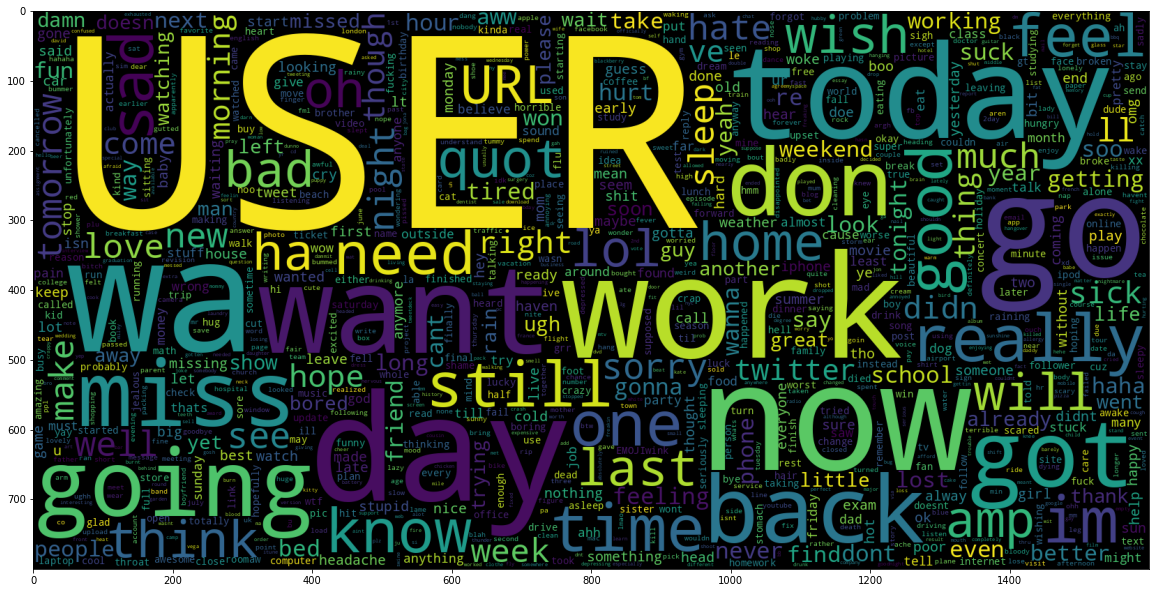

In [6]:
data_negate = processedtext[:800000]
plt.figure(figsize=(20,20))
wc = WordCloud(max_words = 1000, width = 1600, height = 800, collocations=False).generate(" ".join(data_negate))
plt.imshow(wc)

**Word-Cloud for Positive tweets**

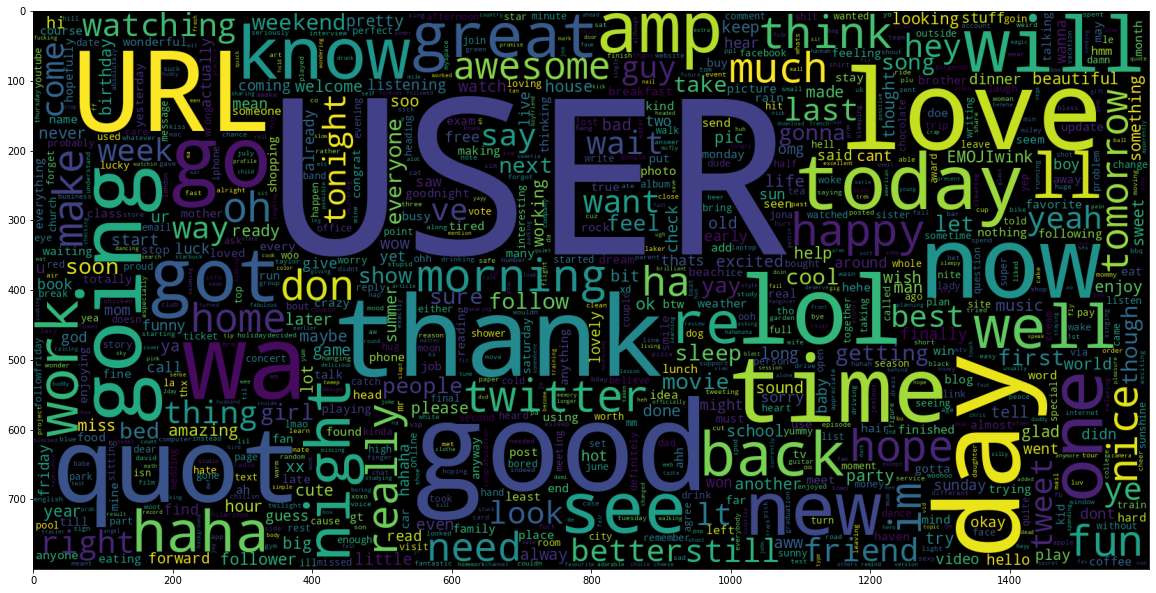

In [7]:
data_postve = processedtext[800000:]
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800, collocations=False).generate(" ".join(data_postve))
plt.figure(figsize = (20,20))
plt.imshow(wc)

## Splitting the data

In [8]:
X_train, X_test, y_train, y_test = train_test_split(processedtext, sentiment, test_size = 0.05, random_state = 0)
print(f'Data Split done.')

Data Split done.


In [9]:
vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=50000)
vectorizer.fit(X_train)
print(f'Vectorizer fitted')
print('No. of feature_words: ',len(vectorizer.get_feature_names()))

Vectorizer fitted
No. of feature_words:  50000


In [10]:
X_train = vectorizer.transform(X_train)
X_test = vectorizer.transform(X_test)
print(f'Data Transformed')

Data Transformed


# Creating and Evaluating Models
Creating 3 different types of model of our sentimental analysis probelms.

- **Bernoulli Naive Baye(Bernoulli)**
- **Linear Support Vector Classificatio (LinearSVC)**
- **Logistic Regression (LR)**


## Evaluation Model Function

In [11]:
def model_evaluate(model):
    y_pred = model.predict(X_test)
    
    # classification report
    print(classification_report(y_test, y_pred))
    
    # confusion report
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    categories = ['Negative', 'Positive']
    
    group_names = ['True Negate', 'False Postve','False Negate','True Postve']
    
    group_percentages = ['{0:.2%}'.format(value) for value in conf_matrix.flatten() / np.sum(conf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(conf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

## BernoulliNB Model

              precision    recall  f1-score   support

           0       0.80      0.78      0.79     39989
           1       0.79      0.80      0.79     40011

    accuracy                           0.79     80000
   macro avg       0.79      0.79      0.79     80000
weighted avg       0.79      0.79      0.79     80000



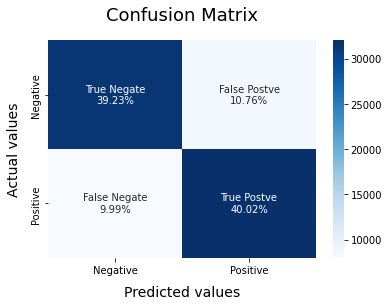

In [12]:
BNBmodel = BernoulliNB(alpha = 2)
BNBmodel.fit(X_train, y_train)
model_evaluate(BNBmodel)

## LinearSVC Model

              precision    recall  f1-score   support

           0       0.83      0.81      0.82     39989
           1       0.81      0.83      0.82     40011

    accuracy                           0.82     80000
   macro avg       0.82      0.82      0.82     80000
weighted avg       0.82      0.82      0.82     80000



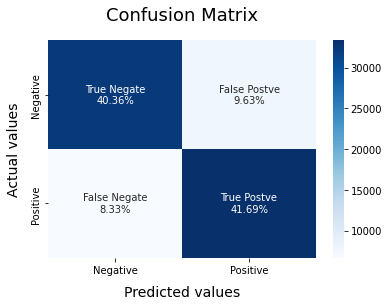

In [13]:
SVCmodel = LinearSVC()
SVCmodel.fit(X_train, y_train)
model_evaluate(SVCmodel)

## Logistic Regression Model

              precision    recall  f1-score   support

           0       0.83      0.81      0.82     39989
           1       0.82      0.83      0.82     40011

    accuracy                           0.82     80000
   macro avg       0.82      0.82      0.82     80000
weighted avg       0.82      0.82      0.82     80000



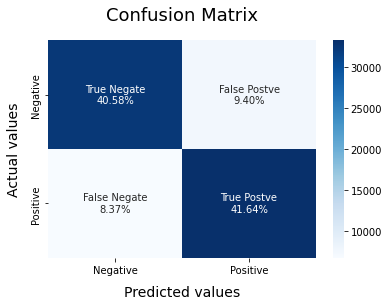

In [14]:
LRmodel = LogisticRegression(C =2, max_iter=1000, n_jobs=1)
LRmodel.fit(X_train, y_train)
model_evaluate(LRmodel)

We can clearly see that the **Logistic Regression Model** performs the best out of all the different models that we tried. It achieves nearly 82% accuracy while classifying the sentiment of a tweet.

Although it should also be noted that the BernoulliNB Model is the fastest to train and predict on. It also achieves 80% accuracy while calssifying.

# Saving the model

In [15]:
file = open('vectoriser-ngram-(1,2).pickle','wb')
pickle.dump(vectorizer, file)
file.close()

file = open('Sentiment-LR.pickle','wb')
pickle.dump(LRmodel, file)
file.close()

file = open('Sentiment-BNB.pickle','wb')
pickle.dump(BNBmodel, file)
file.close()

In [16]:
def load_models():
    '''
    Replace '..path/' by the path of the saved models.
    '''
    
    # Load the vectoriser.
    file = open('..path/vectoriser-ngram-(1,2).pickle', 'rb')
    vectoriser = pickle.load(file)
    file.close()
    # Load the LR Model.
    file = open('..path/Sentiment-LRv1.pickle', 'rb')
    LRmodel = pickle.load(file)
    file.close()
    
    return vectoriser, LRmodel

def predict(vectoriser, model, text):
    # Predict the sentiment
    textdata = vectorizer.transform(preprocess(text))
    sentiment = model.predict(textdata)
    
    # Make a list of text with sentiment.
    data = []
    for text, pred in zip(text, sentiment):
        data.append((text,pred))
        
    # Convert the list into a Pandas DataFrame.
    df = pd.DataFrame(data, columns = ['text','sentiment'])
    df = df.replace([0,1], ["Negative","Positive"])
    return df

if __name__=="__main__":
    # Loading the models.
    #vectoriser, LRmodel = load_models()
    
    # Text to classify should be in a list.
    text = ["I hate our president",
            "I Love you.",
            "Yes! We can win"]
    
    df = predict(vectorizer, LRmodel, text)
    print(df.head())

                   text sentiment
0  I hate our president  Negative
1           I Love you.  Positive
2       Yes! We can win  Positive


**Conclusion**
Out of all the models used for prediction the Logistic Regression model gives the highest accuracy.